# Cat Dogs classification

## Part 1. Basic image processing

### Basic image opening

In [1]:
import numpy as np
import os
from PIL import Image #!pip install pillow
from IPython.display import display

In [2]:
with Image.open('../case_studies/data/cat_dog/train/cat/1.jpg') as my_cat:
    # display(my_cat)
    nparray_cat = np.array(my_cat)
    print(nparray_cat.shape)

(280, 300, 3)


### How to loop through all the files in folder

In [3]:
path = '../case_studies/data/cat_dog/'
img_names = []  #get all the image names --> os.walk

for folder, subfolders, filenames in os.walk(path):
    # print(f"{folder} | {subfolders} | {filenames}")
    #write whatever filtering you want - to get the file you want
    for name in filenames:
        img_names.append(folder + '/' + name)
        
len(img_names)

25007

### Transformation

- In deep learning for computer vision, we often transform our image as either (1) preprocessing step, or for (2) data augmentation

In [4]:
dog = Image.open('../case_studies/data/cat_dog/train/dog/14.jpg')
# dog.size  #h = 500, w = 386
# display(dog)
# dog.getpixel??
# r, g, b = dog.getpixel((0, 0))
# print(r, g, b)  #this will be useful for filtering

In [5]:
type(dog)

PIL.JpegImagePlugin.JpegImageFile

torch.Size([3, 386, 500])


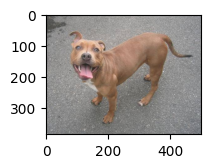

In [6]:
from torchvision import transforms
import matplotlib.pyplot as plt

#most basic transformation, which is making 0-255 to 0-1
transform = transforms.Compose([
    # transforms.RandomRotation(30),
    # transforms.Resize((50)),
    # transforms.CenterCrop(200), ## this is for data augmentation
    transforms.ToTensor()
])
norm_dog = transform(dog)
print(norm_dog.shape)
plt.figure(figsize=(2, 2))
plt.imshow(np.transpose(norm_dog, (1, 2, 0)))

## Part 2. CNN

## Part 3. Using pretrained models